In [1]:
#MODULE-1
from pyspark.sql import SparkSession

# Start SparkSession (you can reuse your existing session too)
spark = SparkSession.builder \
    .appName("BotCampus PySpark Practice") \
    .master("local[*]") \
    .getOrCreate()


In [2]:
#Create dataframe
data = [
    ("Anjali", "Bangalore", 24),
    ("Ravi", "Hyderabad", 28),
    ("Kavya", "Delhi", 22),
    ("Meena", "Chennai", 25),
    ("Arjun", "Mumbai", 30)
]

columns = ["name", "city", "age"]

df = spark.createDataFrame(data, columns)
df.show()


+------+---------+---+
|  name|     city|age|
+------+---------+---+
|Anjali|Bangalore| 24|
|  Ravi|Hyderabad| 28|
| Kavya|    Delhi| 22|
| Meena|  Chennai| 25|
| Arjun|   Mumbai| 30|
+------+---------+---+



In [3]:
#ShowSchema
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- age: long (nullable = true)



In [4]:
#Convert to RDD and Use .collect() + .map()
rdd=df.rdd
print(rdd.collect())
#Extracting names using map
names=rdd.map(lambda row:row['name'])
print(names.collect())

[Row(name='Anjali', city='Bangalore', age=24), Row(name='Ravi', city='Hyderabad', age=28), Row(name='Kavya', city='Delhi', age=22), Row(name='Meena', city='Chennai', age=25), Row(name='Arjun', city='Mumbai', age=30)]
['Anjali', 'Ravi', 'Kavya', 'Meena', 'Arjun']


In [5]:
#MODULE-2
feedback = spark.sparkContext.parallelize([
    "Ravi from Bangalore loved the delivery",
    "Meena from Hyderabad had a late order",
    "Ajay from Pune liked the service",
    "Anjali from Delhi faced UI issues",
    "Rohit from Mumbai gave positive feedback"
])


In [7]:
#Split Lines into Words (flatMap)
words=feedback.flatMap(lambda line:line.split(" "))
print(words.collect())

['Ravi', 'from', 'Bangalore', 'loved', 'the', 'delivery', 'Meena', 'from', 'Hyderabad', 'had', 'a', 'late', 'order', 'Ajay', 'from', 'Pune', 'liked', 'the', 'service', 'Anjali', 'from', 'Delhi', 'faced', 'UI', 'issues', 'Rohit', 'from', 'Mumbai', 'gave', 'positive', 'feedback']


In [8]:
#Remove Stopwords
stopwords = {"from", "the", "a", "an", "had", "gave"}
filtered_words=words.filter(lambda word:word.lower() not in stopwords)
print(filtered_words.collect())


['Ravi', 'Bangalore', 'loved', 'delivery', 'Meena', 'Hyderabad', 'late', 'order', 'Ajay', 'Pune', 'liked', 'service', 'Anjali', 'Delhi', 'faced', 'UI', 'issues', 'Rohit', 'Mumbai', 'positive', 'feedback']


In [10]:
#Word Count using map() + reduceByKey()
word_pairs = filtered_words.map(lambda word: (word.lower(), 1))
word_counts = word_pairs.reduceByKey(lambda a, b: a + b)
print(word_counts.collect())


[('loved', 1), ('liked', 1), ('service', 1), ('anjali', 1), ('faced', 1), ('issues', 1), ('rohit', 1), ('mumbai', 1), ('positive', 1), ('feedback', 1), ('ravi', 1), ('bangalore', 1), ('delivery', 1), ('meena', 1), ('hyderabad', 1), ('late', 1), ('order', 1), ('ajay', 1), ('pune', 1), ('delhi', 1), ('ui', 1)]


In [11]:
#Top 3 Most Frequent Words
top3 = word_counts.takeOrdered(3, key=lambda x: -x[1])
print("Top 3 Words:", top3)



Top 3 Words: [('loved', 1), ('liked', 1), ('service', 1)]


In [12]:
#MODULE-3
#Create marks dataframe
marks_data = [
    ("Amit", "10-A", 89),
    ("Kavya", "10-B", 92),
    ("Anjali", "10-A", 78),
    ("Rohit", "10-B", 85),
    ("Sneha", "10-C", 90)
]

columns1 = ["name", "section", "marks"]

df_marks = spark.createDataFrame(marks_data, columns1)
df_marks.show()


+------+-------+-----+
|  name|section|marks|
+------+-------+-----+
|  Amit|   10-A|   89|
| Kavya|   10-B|   92|
|Anjali|   10-A|   78|
| Rohit|   10-B|   85|
| Sneha|   10-C|   90|
+------+-------+-----+



In [13]:
#Create attendence dataframe
attendance_data = [
    ("Amit", 24),
    ("Kavya", 22),
    ("Anjali", 20),
    ("Rohit", 25),
    ("Sneha", 19)
]

columns2 = ["name", "days_present"]

df_attendance = spark.createDataFrame(attendance_data, columns2)
df_attendance.show()


+------+------------+
|  name|days_present|
+------+------------+
|  Amit|          24|
| Kavya|          22|
|Anjali|          20|
| Rohit|          25|
| Sneha|          19|
+------+------------+



In [15]:
#Join the Two DataFrames
df_joined=df_marks.join(df_attendance,on="name",how="inner")
df_joined.show()

+------+-------+-----+------------+
|  name|section|marks|days_present|
+------+-------+-----+------------+
|  Amit|   10-A|   89|          24|
|Anjali|   10-A|   78|          20|
| Kavya|   10-B|   92|          22|
| Rohit|   10-B|   85|          25|
| Sneha|   10-C|   90|          19|
+------+-------+-----+------------+



In [19]:
#Calculate attendance_rate and grade
from pyspark.sql.functions import col,when
df_final=df_joined.withColumn("attendence_rate",col("days_present")/25)\
.withColumn("grade",when(col("marks")>90,"A")
                  .when(col("marks")>80,"B")
                  .when(col("marks")>70,"C")
                  .when(col("marks")>60,"D")
                  .otherwise("F"))
df_final.show()

+------+-------+-----+------------+---------------+-----+
|  name|section|marks|days_present|attendence_rate|grade|
+------+-------+-----+------------+---------------+-----+
|  Amit|   10-A|   89|          24|           0.96|    B|
|Anjali|   10-A|   78|          20|            0.8|    C|
| Kavya|   10-B|   92|          22|           0.88|    A|
| Rohit|   10-B|   85|          25|            1.0|    B|
| Sneha|   10-C|   90|          19|           0.76|    B|
+------+-------+-----+------------+---------------+-----+



In [21]:
#Filter Students with Good Grades but Poor Attendance (< 80%)
df_filtered=df_final.filter((col("grade")!="C") & (col("attendence_rate")>0.8))
df_filtered.show()


+-----+-------+-----+------------+---------------+-----+
| name|section|marks|days_present|attendence_rate|grade|
+-----+-------+-----+------------+---------------+-----+
| Amit|   10-A|   89|          24|           0.96|    B|
|Kavya|   10-B|   92|          22|           0.88|    A|
|Rohit|   10-B|   85|          25|            1.0|    B|
+-----+-------+-----+------------+---------------+-----+



In [22]:
#Module-4
#Read CSV & JSON → Flatten → Save as Parquet
from google.colab import files
uploaded = files.upload()


Saving employees.json to employees.json
Saving students.csv to students.csv


In [23]:
df_csv = spark.read.option("header", True).csv("/content/students.csv")
df_csv.show(truncate=False)


+------+-----+-------+---------+------+
|emp_id|name |dept   |city     |salary|
+------+-----+-------+---------+------+
|101   |Anil |IT     |Bangalore|80000 |
|102   |Kiran|HR     |Mumbai   |65000 |
|103   |Deepa|Finance|Chennai  |72000 |
+------+-----+-------+---------+------+



In [27]:
#Read and flatten nested json
df_json = spark.read.option("multiline", True).json("/content/employees.json")
df_json.printSchema()
df_json.show(truncate=False)
from pyspark.sql.functions import explode

df_flat = df_json.select(
    "id", "name", "contact", explode("skills").alias("skill")
)
df_flat.show(truncate=False)




root
 |-- contact: struct (nullable = true)
 |    |-- city: string (nullable = true)
 |    |-- email: string (nullable = true)
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- skills: array (nullable = true)
 |    |-- element: string (containsNull = true)

+------------------------------+---+-------+--------------------+
|contact                       |id |name   |skills              |
+------------------------------+---+-------+--------------------+
|{Hyderabad, nandi@example.com}|201|Nandini|[Python, Spark, SQL]|
+------------------------------+---+-------+--------------------+

+---+-------+------------------------------+------+
|id |name   |contact                       |skill |
+---+-------+------------------------------+------+
|201|Nandini|{Hyderabad, nandi@example.com}|Python|
|201|Nandini|{Hyderabad, nandi@example.com}|Spark |
|201|Nandini|{Hyderabad, nandi@example.com}|SQL   |
+---+-------+------------------------------+------+



In [28]:
from pyspark.sql.functions import explode

df_flat = df_json.select(
    "id", "name", "contact", explode("skills").alias("skill")
)
df_flat.show(truncate=False)

+---+-------+------------------------------+------+
|id |name   |contact                       |skill |
+---+-------+------------------------------+------+
|201|Nandini|{Hyderabad, nandi@example.com}|Python|
|201|Nandini|{Hyderabad, nandi@example.com}|Spark |
|201|Nandini|{Hyderabad, nandi@example.com}|SQL   |
+---+-------+------------------------------+------+



In [29]:
#Save to Parquet
df_flat.write.mode("overwrite").parquet("/tmp/employees_flat_parquet")


In [30]:
#MODULE-5
data = [
    ("Kavya", "Math", 95),
    ("Ravi", "Science", 88),
    ("Meena", "Math", 92),
    ("Ajay", "Science", 91),
    ("Kavya", "Science", 93),
    ("Meena", "Science", 85)
]

columns = ["name", "subject", "marks"]

df = spark.createDataFrame(data, columns)
df.show()


+-----+-------+-----+
| name|subject|marks|
+-----+-------+-----+
|Kavya|   Math|   95|
| Ravi|Science|   88|
|Meena|   Math|   92|
| Ajay|Science|   91|
|Kavya|Science|   93|
|Meena|Science|   85|
+-----+-------+-----+



In [31]:
#Register temporary sql view
df.createOrReplaceTempView("students")


In [32]:
#Top Scorer in Each Subject
SELECT subject,name,marks
FROM(SELECT *,ROW_NUMBER() OVER (PARTITION BY subject ORDER BY marks DESC) as rank
     FROM students
)WHERE rank=1

SyntaxError: invalid syntax (ipython-input-365642217.py, line 2)

In [33]:
spark.sql("""
SELECT subject,name,marks
FROM(SELECT *,ROW_NUMBER() OVER (PARTITION BY subject ORDER BY marks DESC) as rank
     FROM students
)WHERE rank=1
""").show()

+-------+-----+-----+
|subject| name|marks|
+-------+-----+-----+
|   Math|Kavya|   95|
|Science|Kavya|   93|
+-------+-----+-----+



In [34]:
#Average Marks Per Subject
spark.sql("""
SELECT subject,AVG(marks) AS avg_marks
FROM students
GROUP BY subject
""").show()

+-------+---------+
|subject|avg_marks|
+-------+---------+
|Science|    89.25|
|   Math|     93.5|
+-------+---------+



In [38]:
#Students Scoring Above Subject Average
spark.sql("""
SELECT s.name,s.subject,s.marks
FROM students s
INNER JOIN(SELECT subject,AVG(marks) AS avg_marks
FROM students
GROUP BY subject
)
avg_table ON s.subject=avg_table.subject
WHERE s.marks > avg_table.avg_marks
""").show()

+-----+-------+-----+
| name|subject|marks|
+-----+-------+-----+
|Kavya|   Math|   95|
| Ajay|Science|   91|
|Kavya|Science|   93|
+-----+-------+-----+



In [39]:
#MODULE-6
pdf = df.toPandas()
pdf.head()


,name,subject,marks
0,Kavya,Math,95
1,Ravi,Science,88
2,Meena,Math,92
3,Ajay,Science,91
4,Kavya,Science,93


In [40]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns




/tmp/ipython-input-4273760948.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_pdf, x="subject", y="avg_marks", palette="viridis")


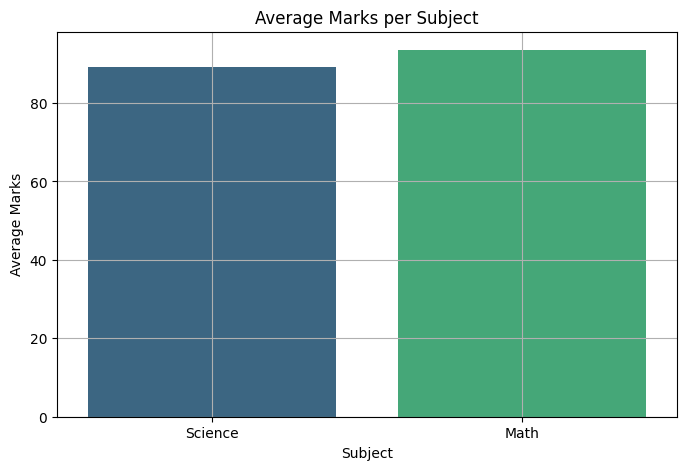

In [42]:
#Bar Plot of Average Marks per Subject
avg_df=spark.sql("""
SELECT subject,AVG(marks) AS avg_marks
FROM students
GROUP BY subject
""")
#NOW CONVERTING IT TO PANDAS
avg_pdf=avg_df.toPandas()
#PLOTTING
plt.figure(figsize=(8,5))
sns.barplot(data=avg_pdf, x="subject", y="avg_marks", palette="viridis")
plt.title("Average Marks per Subject")
plt.xlabel("Subject")
plt.ylabel("Average Marks")
plt.grid(True)
plt.show()

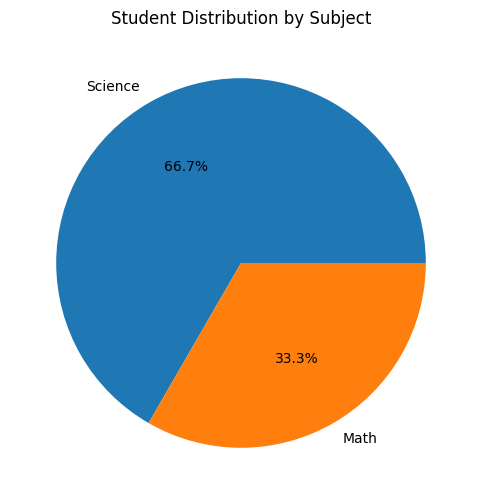

In [44]:
#Pie Chart of Student Count per Subject
count_df = spark.sql("""
SELECT subject, COUNT(*) as student_count
FROM students
GROUP BY subject
""")
#CONVERTING INTO PANDAS
count_pdf = count_df.toPandas()

# PLOTTING
plt.figure(figsize=(6,6))
plt.pie(count_pdf["student_count"], labels=count_pdf["subject"], autopct='%1.1f%%')
plt.title("Student Distribution by Subject")
plt.show()


In [45]:
#MODULE-7
from google.colab import files
uploaded = files.upload()


Saving employee_raw.csv to employee_raw.csv


In [46]:
#read csv
df_emp = spark.read.option("header", True).csv("/content/employee_raw.csv")
df_emp.show(truncate=False)
df_emp.printSchema()


+------+------+-------+------+-----+
|emp_id|name  |dept   |salary|bonus|
+------+------+-------+------+-----+
|1     |Arjun |IT     |75000 |5000 |
|2     |Kavya |HR     |62000 |NULL |
|3     |Sneha |Finance|68000 |4000 |
|4     |Ramesh|Sales  |58000 |NULL |
+------+------+-------+------+-----+

root
 |-- emp_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- dept: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- bonus: string (nullable = true)



In [48]:
#cleaning data
from pyspark.sql.functions import col

df_filtered = df_emp.dropna() \
                    .select("emp_id", "name", "dept", "salary")

df_filtered.show(truncate=False)

+------+-----+-------+------+
|emp_id|name |dept   |salary|
+------+-----+-------+------+
|1     |Arjun|IT     |75000 |
|3     |Sneha|Finance|68000 |
+------+-----+-------+------+



In [49]:
#Load – Save Clean Data to JSON and Parquet
df_filtered = df_emp.dropna().select("emp_id", "name", "dept", "salary")


In [50]:
#Saving as json
df_filtered.write.mode("overwrite").json("/tmp/cleaned_employees.json")


In [52]:
#Saving as parquet
df_filtered.write.mode("overwrite") \
    .partitionBy("dept") \
    .parquet("/tmp/cleaned_employees_partitioned")

